# A9 Customer Segmentation

**Rationale** The idea for this assignment is to give you hands on experience in applying behavioral segmentation techniques to real world data where the variables you use for segmentation are not already created for you (you must define them first). Thus you must first do "feature engineering" before you can do segmentation. Don't worry, this problem is broken down into components.

The dataset we use is [retail invoice](https://drive.google.com/drive/folders/1IUq9xm_0jWEs41iFp8TSWpb0CbPiT87m?usp=sharing). Each invoice is one purchase occassion, and for each invoice we have several observations representing the unique items (stockcode) purchased on that occassion.

The goal of the first part is to create useful features about each consumer's observed behaviors, i.e. go from transaction level to customer level data. The goal of the second part is to then do behavioral segmentation based on these newly constructed features. 

# Part 1 Feature Engineering (5 points)

Generally, feature engineering is where your marketing domain knowledge comes into play. In other words, your intuitions about what matters in terms of separating consumers into different groups should drive what features (aka variables/columns) to create. However, in this assignment, you are expected to compute the characteristics detailed in the following instructions.


Read in the data, preview it, and familiarize yourself with the contents of the data.

In [158]:
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
drive.mount('drive', force_remount=True)

Mounted at drive


In [159]:
fpath = 'drive/MyDrive/Customer Data Analysis/' # change the path here
os.listdir(fpath)

['MyNotes Mod1.ipynb',
 'A1 Treasure Love_Part1.ipynb',
 'A1_Part2.ipynb',
 'MyNotes_Mod2.ipynb',
 'A2 Programming Fundamentals.ipynb',
 'stores A data-set.csv',
 'stores data-set.csv',
 'stores B data-set.csv',
 'stores C data-set.csv',
 'sales data-set.csv',
 '9-8_notes2.ipynb',
 'Colab Notebooks',
 'quebec_yelp_reviews.csv',
 'quebec_biz.csv',
 'Quebec_dataset.csv',
 '9-8_notes.ipynb',
 'A3.ipynb',
 'Copy of InClass_Module_3.ipynb',
 'telecom_churn (1).csv',
 'renttherunway_final_data (1).json',
 'A4.ipynb',
 'Notes_Sept15.ipynb',
 '9 22_Notes.ipynb',
 '9-29_notes.ipynb',
 'facebook_ads.csv',
 'starbucks_promos.csv',
 'A4 F2021 - Visualization.ipynb',
 '10 13_notes.ipynb',
 'temple_traffic.csv',
 'avocado.csv',
 'Untitled0.ipynb',
 'A7 F2021 Regression 2.ipynb',
 'renttherunway_final_data.json',
 'telecom_churn.csv',
 'A5.ipynb',
 'online_invoices.gsheet',
 'online_invoices.csv']

In [160]:
# Read in the data (csv file)
df = pd.read_csv(fpath + 'online_invoices.csv', index_col = 0)

In [161]:
# Preview the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Answer questions here**

What does each row represent? **A** (pick one)

A. 1 invoice (1 point of sale transaction) \\
B. A single item sold \\
C. Each unique item sold in a transaction \\
D. Daily sales \\
E. 1 customer's total purchases on each day



## Unique count variables

Create a dataframe, `df_u` that represents each consumer's total number of transactions and unique products purchased.

Hint: use a `groupby` + `.nunique()` statement. `df.groupby('id')[['var1', 'var2',....]].nunique().reset_index()` will compute the number of unique values of columns 'var1', 'var2',.... for each "id". You should calculate the number of unique `StockCode`'s (like SKU's) and `InvoicesNo`'s for each `CustomerID`. Change your column names in the resulting dataframe, `df_u`, to `['CustomerID', 'NProducts', 'NTrans']`.

In [162]:
# use a groupby operation with the nunique summary function to calculate the number of unique
# product SKU's and transactions for each item
# call the resulting dataframe df_u

df_u = df.groupby('CustomerID')[['InvoiceNo', 'StockCode']].nunique().reset_index()

In [163]:
# rename the columns for unique transactions and products purchased to:
# NTrans and NProducts, respectively 
# Remember, you can either use the syntax dataframe.columns = ['col1', 'col2',....] <- set all the column names using list of strings for each column
# or you can use dataframe.rename(columns = {'oldcolname':'newcolname', 'oldcolname2':'newcolname2', ....}, inplace = True) <- rename only the ones that should be renamed

df_u.columns = ['CustomerID', 'NTrans', 'NProducts']

In [164]:
# take a look at the first 5 rows of resulting dataframe, make sure contents are what you expect

df_u.head()

,CustomerID,NTrans,NProducts
0,12346.0,1,1
1,12347.0,7,103
2,12348.0,4,21
3,12349.0,1,72
4,12350.0,1,16



## Customer spend

Compute the total customer spending and number of units purchased for each customer of this retailer. 

Hint
1. Create a column for `TotalSpend` (unit price x quantity)
1. Use a (groupby + sum) to create a dataframe `df_s` that contains each customer's sum of `TotalSpend` and `Quantity`
1. rename the quantity column to `TotalUnits`


In [165]:
# create total spend column

df['TotalSpend'] = df.UnitPrice * df.Quantity

In [166]:
# create dataframe, df_s, that contains the total spend and quantity for each customer using groupby statement
# remember to reset_index

df_s = df.groupby('CustomerID')[['TotalSpend', 'Quantity']].sum(). reset_index()

In [167]:
# rename columns so that resulting dataframe has columns: CustomerID, TotalSpend, and TotalUnits

df_s.rename(columns = {'Quantity' : 'TotalUnits'}, inplace = True)

In [168]:
# take a look at the first 5 rows of resulting dataframe, make sure contents are what you expect

df_s.head()

,CustomerID,TotalSpend,TotalUnits
0,12346.0,77183.60,74215
1,12347.0,4310.00,2458
2,12348.0,1437.24,2332
3,12349.0,1457.55,630
4,12350.0,294.40,196



## Compute price of average SKU purchased

Compute and create the `AveragePrice` column using the `df_s` dataframe's `TotalUnits` and `TotalSpend`.


In [169]:
# create average price column in df_s

df_s['AveragePrice'] = df_s.TotalSpend/df_s.TotalUnits

In [170]:
# preview df_s to make sure average price is as expected

df_s.head()

,CustomerID,TotalSpend,TotalUnits,AveragePrice
0,12346.0,77183.60,74215,1.040000
1,12347.0,4310.00,2458,1.753458
2,12348.0,1437.24,2332,0.616312
3,12349.0,1457.55,630,2.313571
4,12350.0,294.40,196,1.502041



## Merge `df_u` and `df_s`, call new dataframe df_c (c for "consumer")

Using the variables in `df_c`, compute the following additional column:
1. Spend per transaction (call it "SpendPerTrans")

In total, you should have `df_c` with columns `['CustomerID', 'NTrans', 'NProducts', 'TotalSpend', 'AveragePrice', 'SpendPerTrans']`


**Answer this**

On what column should you merge `df_s` and `df_u`?

* Answer: **merge the two data setss on CustomerID**

In [171]:
# do the merge (review notes from module 3 on merges if necessary)
# use an outer merge, call resulting dataframe, df_c

df_c = df_s.merge(df_u, how = 'outer', on = 'CustomerID')
df_c.head()

,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts
0,12346.0,77183.60,74215,1.040000,1,1
1,12347.0,4310.00,2458,1.753458,7,103
2,12348.0,1437.24,2332,0.616312,4,21
3,12349.0,1457.55,630,2.313571,1,72
4,12350.0,294.40,196,1.502041,1,16


In [172]:
# create the column 'SpendPerTrans'

df_c['SpendPerTrans'] = df_c.TotalSpend/df_c.NTrans


In [173]:
# preview df_c to make sure it looks as expected

df_c.head()

,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans
0,12346.0,77183.60,74215,1.040000,1,1,77183.600000
1,12347.0,4310.00,2458,1.753458,7,103,615.714286
2,12348.0,1437.24,2332,0.616312,4,21,359.310000
3,12349.0,1457.55,630,2.313571,1,72,1457.550000
4,12350.0,294.40,196,1.502041,1,16,294.400000


## Log transformation

1. Plot the histogram of all the variables of df_c other than CustomerID
1. Replace each of these variables with their respective log transformations
1. Plot the histograms again, what's different?

(array([4.25e+03, 6.20e+01, 1.40e+01, 1.00e+00, 4.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 2.00e+00]),
 array([  1. ,  21.5,  42. ,  62.5,  83. , 103.5, 124. , 144.5, 165. ,
        185.5, 206. ]),
 <a list of 10 Patch objects>)

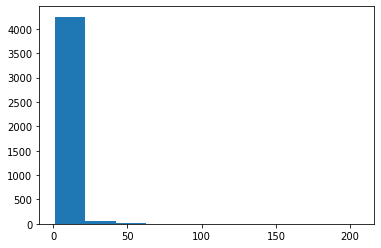

In [174]:
# plot the histogram of NTrans

plt.hist(df_c.NTrans)

(array([4.063e+03, 2.280e+02, 2.900e+01, 7.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([1.0000e+00, 1.7940e+02, 3.5780e+02, 5.3620e+02, 7.1460e+02,
        8.9300e+02, 1.0714e+03, 1.2498e+03, 1.4282e+03, 1.6066e+03,
        1.7850e+03]),
 <a list of 10 Patch objects>)

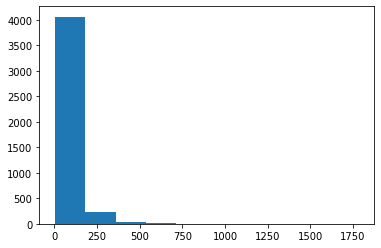

In [175]:
# plot the histogram of NProducts

plt.hist(df_c.NProducts)


(array([4.299e+03, 1.900e+01, 8.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([3.75000000e+00, 2.79171770e+04, 5.58306040e+04, 8.37440310e+04,
        1.11657458e+05, 1.39570885e+05, 1.67484312e+05, 1.95397739e+05,
        2.23311166e+05, 2.51224593e+05, 2.79138020e+05]),
 <a list of 10 Patch objects>)

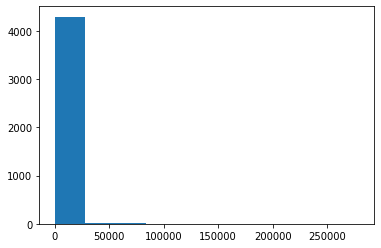

In [176]:
# plot the histogram of TotalSpend

plt.hist(df_c.TotalSpend)

(array([4.307e+03, 1.400e+01, 4.000e+00, 6.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.000000e+00, 1.968530e+04, 3.936960e+04, 5.905390e+04,
        7.873820e+04, 9.842250e+04, 1.181068e+05, 1.377911e+05,
        1.574754e+05, 1.771597e+05, 1.968440e+05]),
 <a list of 10 Patch objects>)

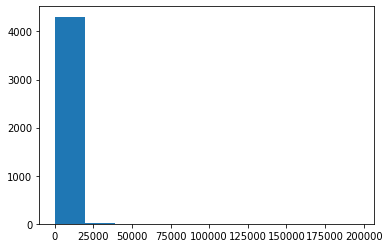

In [177]:
# plot the histogram of TotalUnits

plt.hist(df_c.TotalUnits)

(array([4.327e+03, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([8.56191289e-02, 3.30659002e+01, 6.60461813e+01, 9.90264623e+01,
        1.32006743e+02, 1.64987024e+02, 1.97967306e+02, 2.30947587e+02,
        2.63927868e+02, 2.96908149e+02, 3.29888430e+02]),
 <a list of 10 Patch objects>)

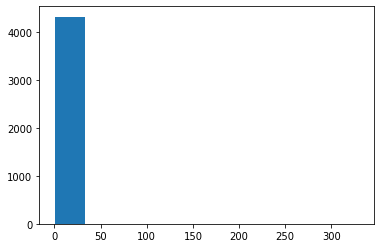

In [178]:
# plot the histogram of AveragePrice

plt.hist(df_c.AveragePrice)

(array([4.329e+03, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([3.750000e+00, 8.427000e+03, 1.685025e+04, 2.527350e+04,
        3.369675e+04, 4.212000e+04, 5.054325e+04, 5.896650e+04,
        6.738975e+04, 7.581300e+04, 8.423625e+04]),
 <a list of 10 Patch objects>)

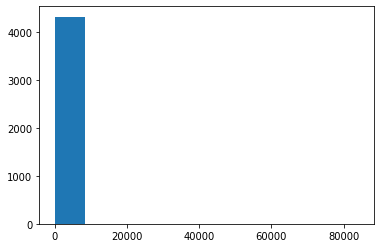

In [179]:
# plot the histogram of SpendPerTrans

plt.hist(df_c.SpendPerTrans)

In [180]:
# Write a loop through all variables of df_c other than CustomerID 
# to replace each column with its log.
# You can start the loop using: for c in df_c.columns[1:]:
# (since df_c.columns[0] is the CustomerID column).
# For some column, c, you can replace the column with its log using:
# dataframe[c] = np.log(dataframe[c]) 
# (of course, use the right variable name for your dataframe)

for c in df_c.columns[1:]:
  df_c[c] = np.log(df_c[c])


(array([1505.,  831.,  897.,  646.,  269.,  115.,   49.,   14.,    5.,
           3.]),
 array([0.        , 0.53278762, 1.06557523, 1.59836285, 2.13115047,
        2.66393808, 3.1967257 , 3.72951332, 4.26230094, 4.79508855,
        5.32787617]),
 <a list of 10 Patch objects>)

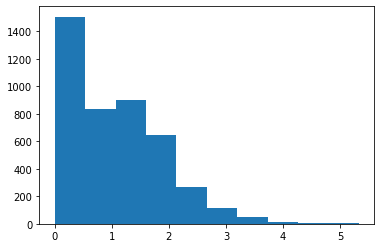

In [181]:
# plot the histogram of NTrans (after taking the log in cell above)

plt.hist(df_c.NTrans)

(array([ 145.,  113.,  377.,  694., 1100.,  998.,  658.,  218.,   26.,
           5.]),
 array([0.        , 0.74871737, 1.49743474, 2.24615211, 2.99486948,
        3.74358685, 4.49230422, 5.24102159, 5.98973896, 6.73845632,
        7.48717369]),
 <a list of 10 Patch objects>)

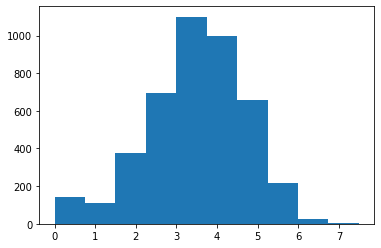

In [182]:
# plot the histogram of NProducts 

plt.hist(df_c.NProducts)

(array([   3.,   15.,  177., 1048., 1475., 1101.,  410.,   74.,   23.,
           8.]),
 array([ 1.32175584,  2.44352642,  3.565297  ,  4.68706758,  5.80883816,
         6.93060874,  8.05237932,  9.1741499 , 10.29592048, 11.41769105,
        12.53946163]),
 <a list of 10 Patch objects>)

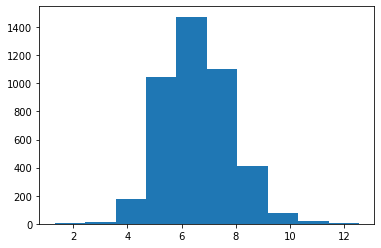

In [183]:
# plot the histogram of TotalSpend 

plt.hist(df_c.TotalSpend)

(array([  11.,   22.,  131.,  701., 1484., 1283.,  578.,   93.,   21.,
          10.]),
 array([ 0.        ,  1.21901668,  2.43803336,  3.65705004,  4.87606673,
         6.09508341,  7.31410009,  8.53311677,  9.75213345, 10.97115013,
        12.19016682]),
 <a list of 10 Patch objects>)

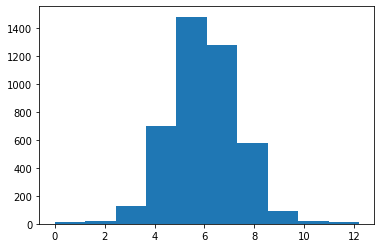

In [184]:
# plot the histogram of TotalUnits

plt.hist(df_c.TotalUnits)

(array([3.000e+00, 2.200e+01, 3.960e+02, 2.844e+03, 9.680e+02, 8.100e+01,
        1.100e+01, 3.000e+00, 4.000e+00, 2.000e+00]),
 array([-2.45784655, -1.63218645, -0.80652634,  0.01913377,  0.84479387,
         1.67045398,  2.49611408,  3.32177419,  4.14743429,  4.9730944 ,
         5.79875451]),
 <a list of 10 Patch objects>)

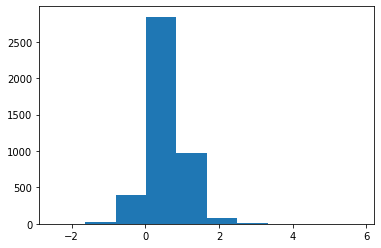

In [185]:
# plot the histogram of AveragePrice 

plt.hist(df_c.AveragePrice)

(array([4.000e+00, 1.400e+01, 1.260e+02, 1.263e+03, 2.327e+03, 5.180e+02,
        6.900e+01, 9.000e+00, 2.000e+00, 2.000e+00]),
 array([ 1.32175584,  2.32371832,  3.3256808 ,  4.32764328,  5.32960576,
         6.33156824,  7.33353071,  8.33549319,  9.33745567, 10.33941815,
        11.34138063]),
 <a list of 10 Patch objects>)

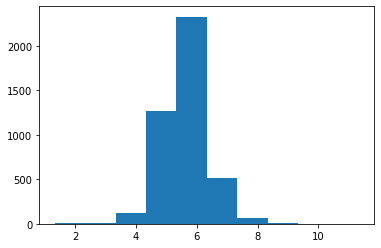

In [186]:
# plot the histogram of SpendPerTrans 

plt.hist(df_c.SpendPerTrans)

**Answer this**

Why might you want to transform these variables by taking logs of each of these variables? (Notice the difference after taking the log transformation)

* Answer: **to distribute the data into a more easily analyzed**

# Create standaradized version of df_c

1. Create `df_c_std` that has all the columns of `df_c` except `CustomerID`.
1. Write a loop through all the columns of `df_c_std` to standardize each column (compute the z-score by subtracting mean and dividing by standard deviation).


In [187]:
# First, create df_c_std by selecting all columns from df_c except CustomerID

df_c_std = df_c.drop(['CustomerID'], axis = 1)

In [188]:
# write a loop to standardize each column of df_c_std
# by replacing each column with (that column - the mean of the column) / std of column
for c in df_c_std.columns:
  df_c_std[c] = (df_c_std[c]-df_c_std[c].mean()) / df_c_std[c].std()


In [189]:
# preview df_c_std to make sure the values have been standardized 

df_c_std.head()

,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans
0,3.718600,3.807404,-1.070471,-1.043705,-2.861400,7.516677
1,1.424214,1.327975,-0.065642,1.119085,0.943194,1.049633
2,0.550901,1.289687,-2.076942,0.497097,-0.362188,0.328660
3,0.562060,0.337414,0.467585,-1.043705,0.649264,2.203153
4,-0.709940,-0.512151,-0.363348,-1.043705,-0.585415,0.061947


**Answer question**

Why is it important to standardize variables before performing clustering?

* Answer: **it's important because all the variables need to be compared on the same scale**

# Part 2 Segmentation (5 points)



## Dimensionality reduction

1. Compute the 2D principal components transformation of `df_c_std`, call this `transformed`
1. Make sure `transformed` is a dataframe, then name the columns 'p0' and 'p1' for principal component 0 and 1, respectively.
1. Add `p0` and `p1` to the df_c dataframe (create the same 2 columns in df_c).

Create a scatter plot of the principal components 0 vs 1. 


**Answer question**

Why might you want to reduce the dimensionality of your data (using PCA) before performing clustering?

* Answer: **You'd want to reduce the dimensionality of the data because there may be too many varibale/characteristics listed for any one customer**

In [190]:
# Use PCA to reduce df_c_std to its first 2 principle components
# store the result as 2 columns in the *df_c* dataframe:
# 'pc1' and 'pc2'


pca = PCA(n_components=2)
transformed = pca.fit_transform(np.array(df_c_std))
transformed.shape

transformed = pd.DataFrame(transformed, columns = ['pc1', 'pc2'])
df_c[['pc1','pc2']] = transformed


In [191]:
# take a look at df_c to make sure principle components are in the dataframe

df_c.head()

,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans,pc1,pc2
0,12346.0,11.253942,11.214722,0.039221,0.000000,0.000000,11.253942,4.916838,0.740811
1,12347.0,8.368693,7.807103,0.561590,1.945910,4.634729,6.422783,2.632158,0.281418
2,12348.0,7.270480,7.754482,-0.484002,1.386294,3.044522,5.884186,1.343655,-1.924887
3,12349.0,7.284512,6.445720,0.838792,0.000000,4.276666,7.284512,1.007478,0.852119
4,12350.0,5.684939,5.278115,0.406825,0.000000,2.772589,5.684939,-1.237310,-0.447156


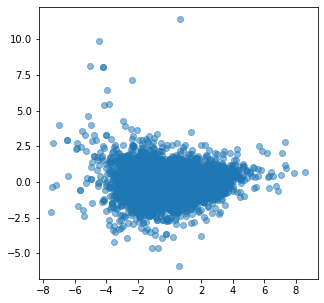

In [192]:
# Create a scatterplot of pc1 vs pc2

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.scatter(df_c.pc1, df_c.pc2, alpha = .5, cmap = 'RdYlGn')



## Segmentation
Using a loop, compute the k-means clustering for $k$ from 2 to 10 segments using the `transformed` dataframe. Store the segment as the column `'seg2'`,`'seg3'`,...,`'seg10'` in the `df_c` dataframe. Make sure you store the inertia metrics in a list called `elbowdata` like in the notes. Create the elbow plot for your k-means clustering. 

1. How many segments does there appear to be based on the elbow plot?
1. Use a loop to plot p0 vs p1 for each segment (different color for each segment)
1. Use a groupby statement to show the mean of the variables in the raw versions (not z-scores) used to conduct the segmentation. e.g. what are the averages of `['NTrans', 'NProducts', 'TotalSpend', 'AveragePrice', 'SpendPerTrans', 'SKUsPerTrans']`

1. In a few sentences, describe what are the characteristics of the resulting segments. Any distinctive segments?

**Hints**
1. Note here that `k` should be the number of clusters at each iteration of your loop, e.g. `for k in ....` 
2. `df_c['seg{}'.format(k)]=` your k-means segmentation to create the `'seg2'`, ..., `'seg15'` columns.

In [193]:
# Write a loop to perform k-means segmentation 
# on the principal component columns, e.g. pc1 and pc2, in *df_c*
# for k from 2 to 10, e.g. for k in range(2,11):
# Be sure to save the inertia metric to create the elbowplot
# see similar example in notes

elbowdata = list()
for k in range(2, 11):
    clusterer = KMeans(n_clusters=k)
    df_c['seg_{}'.format(k)] = clusterer.fit_predict(df_c) 
    inertia = clusterer.inertia_ 
    elbowdata.append([k, inertia])
elbowdata = pd.DataFrame(elbowdata, columns = ['k', 'inertia'])


In [194]:
# preview your dataframe df_c to get an idea of the contents

df_c.head()

,CustomerID,TotalSpend,TotalUnits,AveragePrice,NTrans,NProducts,SpendPerTrans,pc1,pc2,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,seg_9,seg_10
0,12346.0,11.253942,11.214722,0.039221,0.000000,0.000000,11.253942,4.916838,0.740811,0,2,1,2,3,1,2,3,2
1,12347.0,8.368693,7.807103,0.561590,1.945910,4.634729,6.422783,2.632158,0.281418,0,2,1,2,3,1,2,3,2
2,12348.0,7.270480,7.754482,-0.484002,1.386294,3.044522,5.884186,1.343655,-1.924887,0,2,1,2,3,1,2,3,2
3,12349.0,7.284512,6.445720,0.838792,0.000000,4.276666,7.284512,1.007478,0.852119,0,2,1,2,3,1,2,3,2
4,12350.0,5.684939,5.278115,0.406825,0.000000,2.772589,5.684939,-1.237310,-0.447156,0,2,1,2,3,1,2,3,2


**Answer this**
What does each of the segk (for k =1,...,10) columns represent?

1. Answer: **Each segk is a the center of a cluster that's a certain distance from said center**

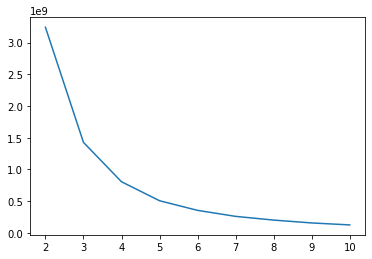

In [195]:
# Create the elbow plot

elbowdata = pd.DataFrame(elbowdata, columns = ['k', 'inertia']) 
plt.plot(elbowdata.k, elbowdata.inertia)

**Answer this**
Based on the eyeball test, where is the "elbow"? i.e. how many clusters seems the "right" number
1. Answer: **3 clusters**

## Inspect segments

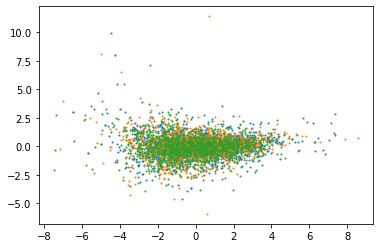

In [196]:
# Write a loop through each of the segments in your optimal KMeans cluster 
# and plot pc1 vs pc2 for that segment
# similar to plotting price vs demand for each region of avocados dataset
# use dot size 1
# e.g.
# for s in df_c['segk'].unique():
#     temp = df_c[df_c['segk'] == s]
#     plt.scatter(temp.pc1, temp.pc2, s = 1)
# where segk is whichever KMeans result you deemed optimal based on previous elbow plot 


for s in df_c['seg_3'].unique():
  temp = df_c[df_c['seg_3'] == s]
  plt.scatter(temp.pc1, temp.pc2, s = 1)


Compute the average of: 
```
NTrans	NProducts	TotalSpend	TotalUnits	AveragePrice SpendPerTrans
```
For each segment of the optimal KMeans segmentation (optimal being the k you found above in elbow plot).

Since these variables in df_c have been log-transformed, use np.exp(the appropriate groupby + mean statement) to take the exponent of the resulting means, i.e. "undo" the log-transformation.

e.g. np.exp(df.groupby('grpvar')['var1', 'var2','var3',...,etc.].mean())

In [197]:
# segment averages

np.exp(df_c.groupby('seg_3')['NTrans', 'NProducts', 'TotalSpend','TotalUnits','AveragePrice', 'SpendPerTrans'].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,NTrans,NProducts,TotalSpend,TotalUnits,AveragePrice,SpendPerTrans
seg_3,,,,,,
0,2.522234,33.460351,707.763620,382.534586,1.850195,280.609861
1,2.580983,31.831486,646.333887,360.673982,1.792017,250.421584
2,2.570149,32.660129,812.488313,451.148599,1.800933,316.124946


**Answer questions below**
1. Which segment buys the most expensive items?
    * Answer: **0**
1. Which segment spends the most? 
    * Answer: **0**
1. Which segment buys the most variety of products?
    * Answer: **0**
1. Which segment buys the  least variety of products?
    * Answer: **1**
1. Are there any segments that seem like they should be combined?
    * Answer: **no**
1. Suppose you want to run some promotions that will get customers to spend more. Pick 2 of the segments that are very different and describe a hypothetical promotional campaign targeted at each (e.g. could be some kind discount with a min. spend qualification, or maybe some kind of a volume discount, etc. - be creative). Explain why each campaign might be a better fit for the targeted segment.
    * Answer: **I would put segment 1 and 2 together and start a BOGO sale which would allow customers to get more than one item, while note spending exactly the same amount..**